In [1]:
# Install necessary libraries
!pip install -q diffusers transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 62.6 MB/s eta 0:00:00


In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from diffusers import StableDiffusionPipeline, DDPMScheduler, UNet2DConditionModel, AutoencoderKL # Import AutoencoderKL
from transformers import CLIPTokenizer, CLIPTextModel
from accelerate import Accelerator
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import torch.nn.functional as F

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
from google.colab import drive
drive.mount('/content/drive')


data_dir = "/content/drive/MyDrive/CLIP_training_data"
metadata_path = os.path.join(data_dir, "metadata.csv")

# Load the CSV file
df = pd.read_csv(metadata_path)


Mounted at /content/drive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Custom Dataset class
class SkinConditionDataset(Dataset):
    def __init__(self, df, tokenizer, img_dir, max_length=77):
        self.df = df
        self.tokenizer = tokenizer
        self.img_dir = img_dir
        self.max_length = max_length
        self.image_transforms = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_path'])
        image = Image.open(img_path).convert('RGB')
        text = row['text']

        example = {}
        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        ).input_ids[0]

        example["pixel_values"] = self.image_transforms(image)

        return example

In [6]:
# Set up the model and tokenizer
model_id = "CompVis/stable-diffusion-v1-4"
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
noise_scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [7]:
# Ensure all models are in float32
text_encoder = text_encoder.float()
vae = vae.float()
unet = unet.float()

In [8]:
# Create dataset and dataloader
dataset = SkinConditionDataset(df, tokenizer, data_dir)
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


In [9]:
# Training settings
num_epochs = 2
learning_rate = 1e-5
max_grad_norm = 1.0
gradient_accumulation_steps = 4

# Initialize optimizer
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)

accelerator = Accelerator(
    gradient_accumulation_steps=gradient_accumulation_steps,
    mixed_precision="fp16",  # Enable mixed precision
)

# Prepare models for training
unet, optimizer, train_dataloader, text_encoder, vae = accelerator.prepare(
    unet, optimizer, train_dataloader, text_encoder, vae
)

In [10]:
# Only train the unet
unet.train()
text_encoder.eval()
vae.eval()

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [11]:
# Training loop
for epoch in range(num_epochs):
    progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
    progress_bar.set_description(f"Epoch {epoch}")

    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(unet):
            # Move models to GPU only when needed
            text_encoder.to(device)
            vae.to(device)

            # Convert images to latent space
            latents = vae.encode(batch["pixel_values"].to(device)).latent_dist.sample()
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device).long()

            # Add noise to the latents according to the noise magnitude at each timestep
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the text embedding for conditioning
            encoder_hidden_states = text_encoder(batch["input_ids"].to(device))[0]

            # Predict the noise residual
            noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

            loss = F.mse_loss(noise_pred, noise, reduction="mean")
            accelerator.backward(loss)

            # Clip gradients
            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(unet.parameters(), max_grad_norm)

            optimizer.step()
            optimizer.zero_grad()

            # Move models back to CPU to free up GPU memory
            text_encoder.to('cpu')
            vae.to('cpu')

        progress_bar.update(1)
        logs = {"loss": loss.detach().item()}
        progress_bar.set_postfix(**logs)

    accelerator.wait_for_everyone()


  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

In [12]:
if accelerator.is_main_process:
    pipeline = StableDiffusionPipeline.from_pretrained(
        model_id,
        unet=accelerator.unwrap_model(unet),
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        vae=vae,
    )
    pipeline.save_pretrained("/content/drive/MyDrive/finetuned_stable_diffusion")


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [13]:
# Generate a sample image
prompt = "photo of herpes on arms on brown skin"
pipeline = pipeline.to(device)
image = pipeline(prompt).images[0]
image.save("/content/drive/MyDrive/sample_generated_image_2.png")

  0%|          | 0/50 [00:00<?, ?it/s]

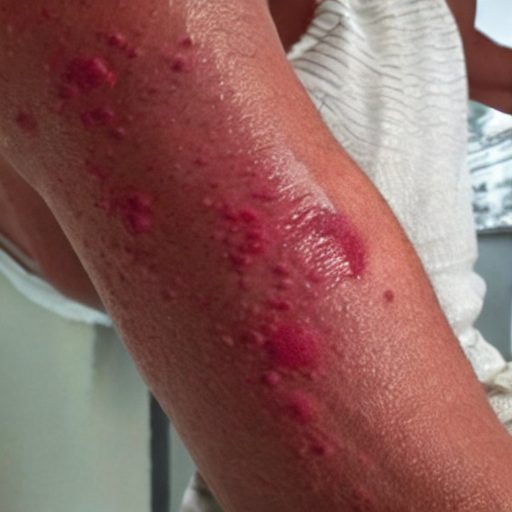

In [15]:

# Display the generated image
from IPython.display import display
display(image)


In [18]:
from huggingface_hub import HfApi, create_repo

# Set your Hugging Face credentials
username = "sayeedahmed"
repo_name = "Derma-finetune-Diffusion-Model"

# Push the model to Hugging Face
pipeline.push_to_hub(
    repo_id=f"{username}/{repo_name}",
    token=token, # Use token directly instead of use_auth_token
    commit_message="Push fine-tuned Stable Diffusion model"
)

print(f"Model pushed to https://huggingface.co/{username}/{repo_name}")

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

Model pushed to https://huggingface.co/sayeedahmed/Derma-finetune-Diffusion-Model
